In [24]:
import numpy as np
import scipy.spatial.distance as sd
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
import os.path
import pdb
#cuda = torch.device('cuda') 
import scipy as sp
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from random import sample
import random
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn import preprocessing
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
import scipy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from scipy import stats
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split

In [25]:
def train_epoch(model, X_train, y_train, opt, criterion, sim, batch_size=200):
    model.train()
    sim = sim
    losses = []
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[beg_i:beg_i + batch_size, :]
        y_batch = y_train[beg_i:beg_i + batch_size]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch.float())
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        #print(loss)
        reg = torch.tensor(0., requires_grad=True)
        for name, param in net.fc1.named_parameters():
            if 'weight' in name:
#                 reg = torch.norm(reg + param @ sim.float() @ param.T, 2)
                M = .5 * ((torch.eye(feature_dim) - sim).T @ (torch.eye(feature_dim) - sim)) + .5 * torch.eye(feature_dim)
                reg = torch.norm(reg + param @ M.float() @ param.T, 2)
                loss += reg
#         for param in model.parameters():
#             loss += .1 * torch.sum(torch.abs(param))
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [26]:
def train_epoch_noreg(model, X_train, y_train, opt, criterion, sim, batch_size=200):
    model.train()
    sim = sim
    losses = []
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[beg_i:beg_i + batch_size, :]
        y_batch = y_train[beg_i:beg_i + batch_size]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch.float())
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        #print(loss)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [27]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, 200)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 50)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(50,5)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

In [29]:
Efeature = pd.read_csv('../data/efeature_filtered.csv',index_col=0)
geneExp = pd.read_csv('../data/expMat_filtered_5000.csv',index_col=0)
label = pd.read_csv('../data/label_visual.csv')
feature_new = pd.read_csv("../data/deepmanreg_latent_500.csv",index_col=0)

x1_np = np.log(geneExp+1).to_numpy()[0:500]
x2_np = preprocessing.scale(Efeature.T.to_numpy(),axis=1)

data = np.concatenate((x1_np,x2_np), axis=0).T
print(data.shape)

distance_matrix = sp.spatial.distance_matrix(feature_new, feature_new)
sim_mat = 1/(1+distance_matrix)
#sim_mat = 1/np.exp(distance_matrix)
sim_mat[sim_mat > np.percentile(sim_mat,50)] = 1
sim_mat[sim_mat != 1] = 0
sim = torch.from_numpy(sim_mat)
sim = sim.fill_diagonal_(0).float()

labels = label.iloc[:,3].to_numpy()

acc_reg = []

pred_reg = []

X = data
y = pd.factorize(labels,sort=True)[0]
for i in range(100):
    #X_train, X_vali, y_train, y_vali = train_test_split(X_train_vali,y_train_vali,test_size=0.2, 
    #                                                    random_state=i, stratify = y_train_vali)
    X_train, X_vali, y_train, y_vali = train_test_split(X,y,test_size=0.2,
                                                        random_state=i, stratify = y)
    X_train_e, X_vali_e, y_train_e, y_vali_e = train_test_split(x1_np.T,y,test_size=0.2,
                                                        random_state=i, stratify = y)
    X_train_t, X_vali_t, y_train_t, y_vali_t = train_test_split(x2_np.T,y,test_size=0.2,
                                                        random_state=i, stratify = y)    
    #print("Before oversampling: ",Counter(y_train))

    # fit and apply the transform
    X_train, y_train = SMOTE(random_state=i).fit_resample(X_train, y_train)
    X_train_e, y_train_e = SMOTE(random_state=i).fit_resample(X_train_e, y_train_e)
    X_train_t, y_train_t = SMOTE(random_state=i).fit_resample(X_train_t, y_train_t)
    #X_vali, y_vali = SMOTE.fit_resample(X_vali, y_vali)
    
    # summarize class distribution
    if i == 0:
        print("After oversampling train: ",Counter(y_train))
        print("Without oversampling Validation: ",Counter(y_vali))
    
    torch.manual_seed(i)
    
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    X_train_e = torch.tensor(X_train_e)
    y_train_e = torch.tensor(y_train_e)
    X_train_t = torch.tensor(X_train_t)
    y_train_t = torch.tensor(y_train_t)
    
    # regulized network 
    feature_dim = 541
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (regularized):",correct_pred)
    acc_reg.append(np.mean(correct_pred))
    pred_reg.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

(3654, 541)
After oversampling train:  Counter({3: 941, 2: 941, 4: 941, 1: 941, 0: 941})
Without oversampling Validation:  Counter({3: 235, 1: 220, 4: 147, 2: 77, 0: 52})
Round 0 Test Accuracy (regularized): 0.53077975376197
Round 1 Test Accuracy (regularized): 0.5157318741450069
Round 2 Test Accuracy (regularized): 0.533515731874145
Round 3 Test Accuracy (regularized): 0.5444596443228454
Round 4 Test Accuracy (regularized): 0.5239398084815321
Round 5 Test Accuracy (regularized): 0.5239398084815321
Round 6 Test Accuracy (regularized): 0.5362517099863201
Round 7 Test Accuracy (regularized): 0.5239398084815321
Round 8 Test Accuracy (regularized): 0.5362517099863201
Round 9 Test Accuracy (regularized): 0.5622435020519836
Round 10 Test Accuracy (regularized): 0.5006839945280438
Round 11 Test Accuracy (regularized): 0.5047879616963065
Round 12 Test Accuracy (regularized): 0.560875512995896
Round 13 Test Accuracy (regularized): 0.5266757865937073
Round 14 Test Accuracy (regularized): 0.51299

In [30]:
np.mean(pred_reg)

0.5343775649794802

In [23]:
pred_reg = np.array(pred_reg)
np.savetxt("../data/pred_reg_100.csv", pred_reg, delimiter=",")

# Classify layer

In [11]:
Efeature = pd.read_csv('../data/efeature_filtered.csv',index_col=0)
geneExp = pd.read_csv('../data/expMat_filtered.csv',index_col=0)
label = pd.read_csv('../data/label_visual.csv')
feature_new = pd.read_csv("../data/deepmanreg_latent.csv",index_col=0)
ma_latent = pd.read_csv("../data/ma_latent.csv").to_numpy()
cca_latent = pd.read_csv("../data/cca_latent.csv").to_numpy()
matcher_latent = pd.read_csv("../data/matcher_latent.csv").to_numpy()

#x1_np = preprocessing.scale(np.log(geneExp+1).to_numpy(),axis=1)
#x2_np = preprocessing.scale(Efeature.T.to_numpy(),axis=1)

x1_np = np.log(geneExp+1).to_numpy()
x2_np = preprocessing.scale(Efeature.T.to_numpy(),axis=1)

data = np.concatenate((x1_np,x2_np), axis=0).T
print(data.shape)

distance_matrix = sp.spatial.distance_matrix(feature_new, feature_new)
sim_mat = 1/(1+distance_matrix)
#sim_mat = 1/np.exp(distance_matrix)
sim_mat[sim_mat > np.percentile(sim_mat,50)] = 1
sim_mat[sim_mat != 1] = 0
sim = torch.from_numpy(sim_mat)
sim = sim.fill_diagonal_(0).float()

distance_matrix2 = sp.spatial.distance_matrix(ma_latent,ma_latent)
sim_mat2 = 1/(1+distance_matrix2)
sim_mat2[sim_mat2 > np.percentile(sim_mat2,50)] = 1
sim_mat2[sim_mat2 != 1] = 0
sim2 = torch.from_numpy(sim_mat2)
sim2 = sim2.fill_diagonal_(0).float()

distance_matrix3 = sp.spatial.distance_matrix(cca_latent,cca_latent)
sim_mat3 = 1/(1+distance_matrix3)
sim_mat3[sim_mat3 > np.percentile(sim_mat3,50)] = 1
sim_mat3[sim_mat3 != 1] = 0
sim3 = torch.from_numpy(sim_mat3)
sim3 = sim3.fill_diagonal_(0).float()

distance_matrix4 = sp.spatial.distance_matrix(matcher_latent,matcher_latent)
sim_mat4 = 1/(1+distance_matrix4)
sim_mat4[sim_mat4 > np.percentile(sim_mat4,50)] = 1
sim_mat4[sim_mat4 != 1] = 0
sim4 = torch.from_numpy(sim_mat4)
sim4 = sim4.fill_diagonal_(0).float()

labels = label.iloc[:,3].to_numpy()

(3654, 1041)


# train test split

In [12]:
acc_reg = []
acc_noreg = []
acc_e = []
acc_t = []
acc_ma = []
acc_cca = []
acc_matcher = []

pred_reg = []
pred_noreg = []
pred_e = []
pred_t = []
pred_ma = []
pred_cca = []
pred_matcher = []

#weights = [448,719,43,214,1456,684]
#weights = {3: 1176, 1: 1097, 4: 734, 2: 385, 0: 262}
#weights = [1 - (x / sum(weights)) for x in weights]
#weights = torch.tensor(weights, dtype=torch.float32)
X = data
y = pd.factorize(labels,sort=True)[0]
#X_train_vali, X_test, y_train_vali, y_test = train_test_split(X,y,test_size=0.2, 
#                                                        random_state=0, stratify = y)
#X_test, y_test = SMOTE.fit_resample(X_test, y_test)
#print("After oversampling test: ",Counter(y_test))
#X, y = SMOTE.fit_resample(X, y)
for i in range(100):
    #X_train, X_vali, y_train, y_vali = train_test_split(X_train_vali,y_train_vali,test_size=0.2, 
    #                                                    random_state=i, stratify = y_train_vali)
    X_train, X_vali, y_train, y_vali = train_test_split(X,y,test_size=0.2,
                                                        random_state=i, stratify = y)
    X_train_e, X_vali_e, y_train_e, y_vali_e = train_test_split(x1_np.T,y,test_size=0.2,
                                                        random_state=i, stratify = y)
    X_train_t, X_vali_t, y_train_t, y_vali_t = train_test_split(x2_np.T,y,test_size=0.2,
                                                        random_state=i, stratify = y)    
    #print("Before oversampling: ",Counter(y_train))

    # fit and apply the transform
    X_train, y_train = SMOTE(random_state=i).fit_resample(X_train, y_train)
    X_train_e, y_train_e = SMOTE(random_state=i).fit_resample(X_train_e, y_train_e)
    X_train_t, y_train_t = SMOTE(random_state=i).fit_resample(X_train_t, y_train_t)
    #X_vali, y_vali = SMOTE.fit_resample(X_vali, y_vali)
    
    # summarize class distribution
    if i == 0:
        print("After oversampling train: ",Counter(y_train))
        print("Without oversampling Validation: ",Counter(y_vali))
    
    torch.manual_seed(i)
    
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    X_train_e = torch.tensor(X_train_e)
    y_train_e = torch.tensor(y_train_e)
    X_train_t = torch.tensor(X_train_t)
    y_train_t = torch.tensor(y_train_t)
    
    # no regulized network
    feature_dim = 1041
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch_noreg(net, X_train, y_train, opt, criterion, sim)
    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (unregularized):",correct_pred)
    acc_noreg.append(np.mean(correct_pred)) 
    pred_noreg.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    # no regulized network e-feature
    feature_dim = 1000
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch_noreg(net, X_train_e, y_train_e, opt, criterion, sim)
    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali_e).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali_e[i]) for i in range(len(y_vali_e))])
    print("Round",i,"Test Accuracy (unregularized e-feature):",correct_pred)
    acc_e.append(np.mean(correct_pred)) 
    pred_e.append([float(y_pred_tags[i] == y_vali_e[i]) for i in range(len(y_vali_e))])

    # no regulized network gene-exp
    feature_dim = 41
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch_noreg(net, X_train_t, y_train_t, opt, criterion, sim)
    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali_t).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali_t[i]) for i in range(len(y_vali_t))])
    print("Round",i,"Test Accuracy (unregularized gene exp):",correct_pred)
    acc_t.append(np.mean(correct_pred)) 
    pred_t.append([float(y_pred_tags[i] == y_vali_t[i]) for i in range(len(y_vali_t))])
    
    # regulized network 
    feature_dim = 1041
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (regularized):",correct_pred)
    acc_reg.append(np.mean(correct_pred))
    pred_reg.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    # manifold alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim2)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (manifold alignment):",correct_pred)
    acc_ma.append(np.mean(correct_pred))
    pred_ma.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    #cca alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (cca):",correct_pred)
    acc_cca.append(np.mean(correct_pred))
    pred_cca.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    #matcher alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (matcher):",correct_pred)
    acc_matcher.append(np.mean(correct_pred))
    pred_matcher.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

After oversampling train:  Counter({3: 941, 2: 941, 4: 941, 1: 941, 0: 941})
Without oversampling Validation:  Counter({3: 235, 1: 220, 4: 147, 2: 77, 0: 52})
Round 0 Test Accuracy (unregularized): 0.07113543091655267
Round 0 Test Accuracy (unregularized e-feature): 0.28864569083447333
Round 0 Test Accuracy (unregularized gene exp): 0.4582763337893297
Round 0 Test Accuracy (regularized): 0.53077975376197
Round 0 Test Accuracy (manifold alignment): 0.4418604651162791
Round 0 Test Accuracy (cca): 0.41450068399452805
Round 0 Test Accuracy (matcher): 0.43365253077975374
Round 1 Test Accuracy (unregularized): 0.39398084815321477
Round 1 Test Accuracy (unregularized e-feature): 0.06976744186046512
Round 1 Test Accuracy (unregularized gene exp): 0.42818057455540354
Round 1 Test Accuracy (regularized): 0.48153214774281805
Round 1 Test Accuracy (manifold alignment): 0.4021887824897401
Round 1 Test Accuracy (cca): 0.4103967168262654
Round 1 Test Accuracy (matcher): 0.4186046511627907
Round 2 Tes

KeyboardInterrupt: 

In [29]:
scipy.stats.ks_2samp(acc_reg,acc_noreg,alternative='less')

KstestResult(statistic=0.89, pvalue=4.28267736805192e-42)

In [18]:
acc_e[0:5]

[0.39261285909712723,
 0.07113543091655267,
 0.07113543091655267,
 0.5253077975376197,
 0.07113543091655267]

In [20]:
acc_noreg[0:5]

[0.07113543091655267,
 0.4528043775649795,
 0.07113543091655267,
 0.07113543091655267,
 0.28317373461012313]

In [30]:
np.percentile(acc_t,[2.5,50,97.5])

array([0.40420657, 0.44049248, 0.47352941])

In [26]:
acc_all = np.array([acc_noreg,acc_reg,acc_ma,acc_cca,acc_matcher,acc_e,acc_t])

In [44]:
np.mean(acc_t)

0.44032831737346095

In [20]:
pred_reg = np.array(pred_reg)
pred_noreg = np.array(pred_noreg)
pred_ma= np.array(pred_ma)
pred_cca = np.array(pred_cca)
pred_matcher = np.array(pred_matcher)
pred_e = np.array(pred_e)
pred_t = np.array(pred_t)

In [40]:
np.savetxt("../data/pred_reg.csv", pred_reg, delimiter=",")
np.savetxt("../data/pred_noreg.csv", pred_noreg, delimiter=",")
np.savetxt("../data/pred_ma.csv", pred_ma, delimiter=",")
np.savetxt("../data/pred_cca.csv", pred_cca, delimiter=",")
np.savetxt("../data/pred_matcher.csv", pred_matcher, delimiter=",")
np.savetxt("../data/pred_e.csv", pred_e, delimiter=",")
np.savetxt("../data/pred_t.csv", pred_t, delimiter=",")
np.savetxt("../data/y_vali.csv", y_vali, delimiter=",")
np.savetxt("../data/acc_all.csv", acc_all, delimiter=",")

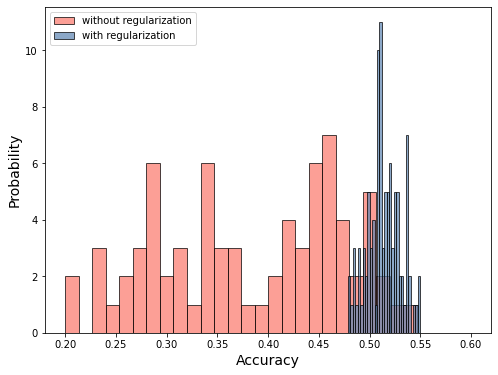

In [30]:
plt.figure(figsize=(8,6))
reg = plt.hist(acc_noreg, bins=30, range=[0.2, 0.6],color = "#FC766AFF",alpha=0.7,density=False, histtype='bar', ec='black')
noreg = plt.hist(acc_reg, bins=30, alpha=0.7,color = "#5B84B1FF",density=False, histtype='bar', ec='black')
plt.xlabel("Accuracy", size=14)
plt.ylabel("Probability", size=14)
#plt.title("Histograms for validation accuracy")
plt.legend(['without regularization', 'with regularization'])
plt.savefig("../figure/hist_validation.pdf")

F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-leve

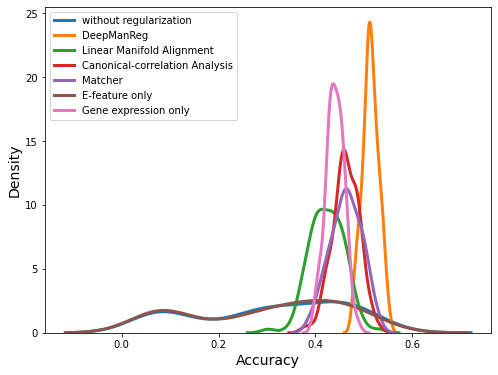

In [39]:
plt.figure(figsize=(8,6))
sns.distplot(acc_noreg, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_reg, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_ma, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_cca, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_matcher, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_e, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
sns.distplot(acc_t, hist = False, kde = True, norm_hist=True,kde_kws = { 'linewidth': 3})
plt.xlabel("Accuracy", size=14)
plt.ylabel("Density", size=14)
#plt.title("Histograms for validation accuracy")
plt.legend(['without regularization', 'DeepManReg',"Linear Manifold Alignment","Canonical-correlation Analysis","Matcher",
            "E-feature only","Gene expression only"])
plt.savefig("../figure/density_validation.pdf")

# Final Model

In [7]:
#network for all data
feature_dim = 1041
X = data
y = pd.factorize(labels,sort=True)[0]
X, y = SMOTE(random_state = 0).fit_resample(X, y)
print("After oversampling whole: ",Counter(y))

X = torch.tensor(X)
y = torch.tensor(y)
    
torch.manual_seed(0)
np.random.seed(0)
net = Net()
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
e_losses = []
num_epochs = 20
for e in range(num_epochs):
    e_losses += train_epoch(net, X, y, opt, criterion, sim)

with torch.no_grad():
x_tensor_test = X.float()#.to(device)
    net.eval()
    yhat = net(x_tensor_test)
y_pred_softmax = torch.log_softmax(yhat, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
correct_pred = np.mean([float(y_pred_tags[i] == y[i]) for i in range(len(y))])
print("Train Accuracy (regularized):",correct_pred)

After oversampling whole:  Counter({3: 1176, 1: 1176, 4: 1176, 2: 1176, 0: 1176})
Train Accuracy (regularized): 0.6299319727891156


In [55]:
features = geneExp.index.tolist()+Efeature.columns.tolist()
colnames = ["L1","L2/3","L4","L5","L6"]
score_df = pd.DataFrame(index = features)
for i in range(5):
    ig = IntegratedGradients(net)
    x_tensor_test.requires_grad_()
    attr, delta = ig.attribute(x_tensor_test[y==i],target=1, return_convergence_delta=True)
    attr = attr.detach().numpy()
    score_df[colnames[i]] = np.mean(attr, axis=0)

In [56]:
score_df.to_csv("../data/integradint_.csv", index=False, header=False)

,L1,L2/3,L4,L5,L6
Adarb2,0.007638,0.000268,0.001206,0.002147,0.001678
Sst,-0.002523,-0.004337,-0.009737,-0.014670,-0.012037
Vip,-0.001402,-0.001714,0.000181,-0.000144,-0.000004
Npy,-0.017017,-0.008731,-0.010355,-0.010180,-0.009723
Synpr,0.012129,0.018529,0.029359,0.033299,0.023059
...,...,...,...,...,...
fast_trough_v_short_square,-0.000643,0.000631,-0.000634,-0.000500,-0.001059
fast_trough_t_short_square,0.000833,0.000114,-0.000378,-0.000129,-0.000020
threshold_v_short_square,0.000747,0.000519,-0.000390,-0.000046,-0.000075
threshold_i_short_square,0.000375,-0.000309,-0.000118,0.000090,0.000305


# ROC curve

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
fpr = dict()
tpr = dict()
roc_auc = dict()
real = label_binarize(y, classes=range(5))
pred = y_pred_softmax.detach().numpy()
#pred = net(X_train.float()).detach().numpy()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(real[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(real.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda3-64bit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-leve

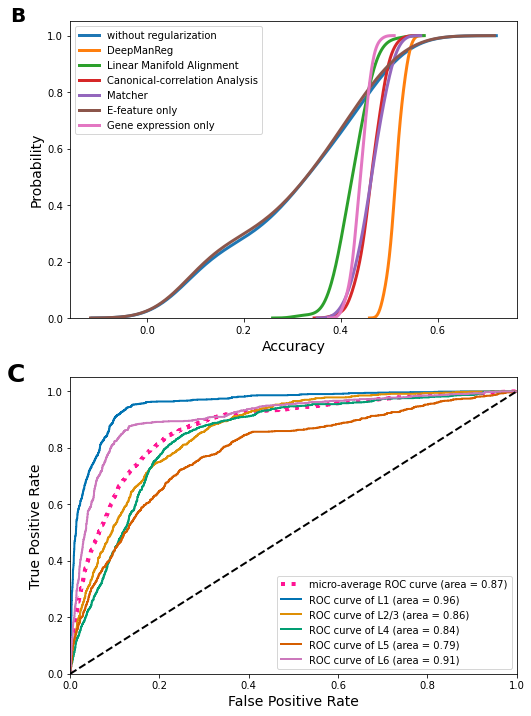

In [46]:
# Plot all ROC curves
layer=["L1","L2/3","L4","L5","L6"]
plt.figure(figsize=(8,12))
ax=plt.subplot(211)
sns.distplot(acc_noreg, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_reg, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_ma, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_cca, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_matcher, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_e, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
sns.distplot(acc_t, hist = False, kde = True,kde_kws = { 'linewidth': 3,'cumulative': True})
plt.xlabel("Accuracy", size=14)
plt.ylabel("Probability", size=14)
#plt.title("Histograms for validation accuracy")
plt.legend(['without regularization', 'DeepManReg',"Linear Manifold Alignment","Canonical-correlation Analysis","Matcher",
            "E-feature only","Gene expression only"])
#plt.savefig("../figure/hist_validation.eps")
ax.text(-0.1, 1.05, "B", transform=ax.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
lw = 2
ax=plt.subplot(212)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = sns.color_palette("colorblind")
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of '+layer[i]+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.title('')
plt.legend(loc="lower right")
ax.text(-0.1, 1.05, "C", transform=ax.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')
plt.savefig("../figure/Roc_curve.eps")
plt.savefig("../figure/Roc_curve.pdf")
plt.savefig("../figure/Roc_curve.png")
plt.show()

# Classify t-type

In [16]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, 200)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 50)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(50,6)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
acc_reg_t = []
acc_noreg_t = []
acc_ma_t = []
acc_cca_t = []
acc_matcher_t = []

pred_reg_t = []
pred_noreg_t = []
pred_ma_t = []
pred_cca_t = []
pred_matcher_t = []

#weights = [448,719,43,214,1456,684]
#weights = {3: 1176, 1: 1097, 4: 734, 2: 385, 0: 262}
#weights = [1 - (x / sum(weights)) for x in weights]
#weights = torch.tensor(weights, dtype=torch.float32)
X = data
labels = label.iloc[:,1].to_numpy()
y = pd.factorize(labels,sort=True)[0]
#X_train_vali, X_test, y_train_vali, y_test = train_test_split(X,y,test_size=0.2, 
#                                                        random_state=0, stratify = y)
#X_test, y_test = SMOTE.fit_resample(X_test, y_test)
#print("After oversampling test: ",Counter(y_test))
#X, y = SMOTE.fit_resample(X, y)
for i in range(100):
    #X_train, X_vali, y_train, y_vali = train_test_split(X_train_vali,y_train_vali,test_size=0.2, 
    #                                                    random_state=i, stratify = y_train_vali)
    X_train, X_vali, y_train, y_vali = train_test_split(X,y,test_size=0.2,
                                                        random_state=i, stratify = y)
    
    #print("Before oversampling: ",Counter(y_train))

    # fit and apply the transform
    X_train, y_train = SMOTE(random_state=i).fit_resample(X_train, y_train)
    #X_vali, y_vali = SMOTE.fit_resample(X_vali, y_vali)
    # summarize class distribution
    if i == 0:
        print("After oversampling train: ",Counter(y_train))
        print("Without oversampling Validation: ",Counter(y_vali))
    
    torch.manual_seed(i)
    
    X_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    
    # no regulized network
    feature_dim = 1041
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch_noreg(net, X_train, y_train, opt, criterion, sim)
    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (unregularized):",correct_pred)
    acc_noreg_t.append(np.mean(correct_pred)) 
    pred_noreg_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    # regulized network   
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (regularized):",correct_pred)
    acc_reg_t.append(np.mean(correct_pred))
    pred_reg_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    # manifold alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim2)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (manifold alignment):",correct_pred)
    acc_ma_t.append(np.mean(correct_pred))
    pred_ma_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    
    #cca alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (cca):",correct_pred)
    acc_cca_t.append(np.mean(correct_pred))
    pred_cca_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

    #matcher alignment
    net = Net()
    opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    e_losses = []
    num_epochs = 20
    for e in range(num_epochs):
        e_losses += train_epoch(net, X_train, y_train, opt, criterion, sim3)

    with torch.no_grad():
        x_tensor_test = torch.from_numpy(X_vali).float()#.to(device)
        net.eval()
        yhat = net(x_tensor_test)
    y_pred_softmax = torch.log_softmax(yhat, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = np.mean([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])
    print("Round",i,"Test Accuracy (matcher):",correct_pred)
    acc_matcher_t.append(np.mean(correct_pred))
    pred_matcher_t.append([float(y_pred_tags[i] == y_vali[i]) for i in range(len(y_vali))])

After oversampling train:  Counter({4: 1237, 1: 1237, 3: 1237, 5: 1237, 0: 1237, 2: 1237})
Without oversampling Validation:  Counter({4: 309, 1: 144, 5: 137, 0: 90, 3: 43, 2: 8})
Round 0 Test Accuracy (unregularized): 0.7674418604651163
Round 0 Test Accuracy (regularized): 0.8974008207934336
Round 0 Test Accuracy (manifold alignment): 0.03146374829001368
Round 0 Test Accuracy (cca): 0.8002735978112175
Round 0 Test Accuracy (matcher): 0.7291381668946648
Round 1 Test Accuracy (unregularized): 0.7168262653898769
Round 1 Test Accuracy (regularized): 0.8946648426812586
Round 1 Test Accuracy (manifold alignment): 0.16826265389876882
Round 1 Test Accuracy (cca): 0.707250341997264
Round 1 Test Accuracy (matcher): 0.9151846785225718
Round 2 Test Accuracy (unregularized): 0.39398084815321477
Round 2 Test Accuracy (regularized): 0.9069767441860465
Round 2 Test Accuracy (manifold alignment): 0.8495212038303693
Round 2 Test Accuracy (cca): 0.8440492476060192
Round 2 Test Accuracy (matcher): 0.71682

Round 28 Test Accuracy (cca): 0.6470588235294118
Round 28 Test Accuracy (matcher): 0.5430916552667578
Round 29 Test Accuracy (unregularized): 0.8864569083447332
Round 29 Test Accuracy (regularized): 0.9124487004103967
Round 29 Test Accuracy (manifold alignment): 0.12448700410396717
Round 29 Test Accuracy (cca): 0.7031463748290013
Round 29 Test Accuracy (matcher): 0.7975376196990424
Round 30 Test Accuracy (unregularized): 0.7879616963064295
Round 30 Test Accuracy (regularized): 0.920656634746922
Round 30 Test Accuracy (manifold alignment): 0.3543091655266758
Round 30 Test Accuracy (cca): 0.7510259917920656
Round 30 Test Accuracy (matcher): 0.7346101231190151
Round 31 Test Accuracy (unregularized): 0.8030095759233926
Round 31 Test Accuracy (regularized): 0.9233926128590971
Round 31 Test Accuracy (manifold alignment): 0.6812585499316005
Round 31 Test Accuracy (cca): 0.7783857729138167
Round 31 Test Accuracy (matcher): 0.7414500683994528
Round 32 Test Accuracy (unregularized): 0.7633378932

Round 57 Test Accuracy (matcher): 0.8399452804377565
Round 58 Test Accuracy (unregularized): 0.8235294117647058
Round 58 Test Accuracy (regularized): 0.9370725034199726
Round 58 Test Accuracy (manifold alignment): 0.16415868673050615
Round 58 Test Accuracy (cca): 0.7154582763337893
Round 58 Test Accuracy (matcher): 0.8385772913816689
Round 59 Test Accuracy (unregularized): 0.320109439124487
Round 59 Test Accuracy (regularized): 0.8700410396716827
Round 59 Test Accuracy (manifold alignment): 0.3707250341997264
Round 59 Test Accuracy (cca): 0.5129958960328317
Round 59 Test Accuracy (matcher): 0.7017783857729138
Round 60 Test Accuracy (unregularized): 0.9165526675786594
Round 60 Test Accuracy (regularized): 0.896032831737346
Round 60 Test Accuracy (manifold alignment): 0.3857729138166895
Round 60 Test Accuracy (cca): 0.5499316005471956
Round 60 Test Accuracy (matcher): 0.5143638850889193
Round 61 Test Accuracy (unregularized): 0.4158686730506156
Round 61 Test Accuracy (regularized): 0.874

Round 87 Test Accuracy (unregularized): 0.9548563611491108
Round 87 Test Accuracy (regularized): 0.9151846785225718
Round 87 Test Accuracy (manifold alignment): 0.6963064295485636
Round 87 Test Accuracy (cca): 0.7496580027359782
Round 87 Test Accuracy (matcher): 0.7948016415868673
Round 88 Test Accuracy (unregularized): 0.31600547195622436
Round 88 Test Accuracy (regularized): 0.9124487004103967
Round 88 Test Accuracy (manifold alignment): 0.4582763337893297
Round 88 Test Accuracy (cca): 0.7701778385772914
Round 88 Test Accuracy (matcher): 0.667578659370725
Round 89 Test Accuracy (unregularized): 0.8290013679890561
Round 89 Test Accuracy (regularized): 0.9343365253077975
Round 89 Test Accuracy (manifold alignment): 0.2270861833105335
Round 89 Test Accuracy (cca): 0.7154582763337893
Round 89 Test Accuracy (matcher): 0.774281805745554
Round 90 Test Accuracy (unregularized): 0.8549931600547196
Round 90 Test Accuracy (regularized): 0.9138166894664843
Round 90 Test Accuracy (manifold alignm

In [39]:
np.percentile(acc_matcher_t,[2.5,97.5])

array([0.50646375, 0.89097127])

In [45]:
np.mean(acc_ma_t)

0.3500957592339261

In [17]:
acc_all_t = np.array([acc_noreg_t,acc_reg_t,acc_ma_t,acc_cca_t,acc_matcher_t])
np.savetxt("../data/acc_all_t.csv", acc_all_t, delimiter=",")